In [ ]:
# Mount google drive
from google.colab import drive
import gc

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install statsmodels --upgrade

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import statsmodels
from scipy.stats import shapiro

In [ ]:
%cd ./drive/My Drive/SUNY_Poly_DSA598/datasets/FEVER/

/content/drive/My Drive/SUNY_Poly_DSA598/datasets/FEVER


In [ ]:
!ls -a

AVeriTeC			 fever-scorer	    paper_test.jsonl
.DS_Store			 fever-train.jsonl  tabular_sets
fever2-adversarial.jsonl	 GPT_sets	    wiki-pages
feverous_train_challenges.jsonl  paper_dev.jsonl


In [ ]:
def load_jsonl(file_path, encoding='utf-8'):
    """Loads a JSON Lines file into a list of Python objects."""
    data = []
    with open(file_path, 'r', encoding=encoding) as f:  # Specify encoding for safety
        for line in f:
            data.append(json.loads(line))  # Parse each line individually
    return data

In [ ]:
# Data paths (replace with your actual paths if different)
fever_path = "./datasets/FEVER/"
train_clf_path = f"tabular_sets/tabular_clf_paper_dev_train/v1_segmented_sentIDs_n3461_04-04_002.csv"
valid_clf_path = f"tabular_sets/tabular_clf_paper_dev_valid/v1_segmented_sentIDs_n1482_04-04_002.csv"
train_sentEx_path = f"tabular_sets/tabular_sentEx_paper_dev_train/v1_segmented_sentIDs_n3461_04-04_002.csv"
valid_sentEx_path = f"tabular_sets/tabular_sentEx_paper_dev_valid/v1_segmented_sentIDs_n1482_04-04_002.csv"
test_path = f"paper_test.jsonl"
train_path = f"paper_dev.jsonl"

# Load datasets
train_clf = pd.read_csv(train_clf_path)
valid_clf = pd.read_csv(valid_clf_path)
train_sentEx = pd.read_csv(train_sentEx_path)
valid_sentEx = pd.read_csv(valid_sentEx_path)
test_jsonl = load_jsonl(test_path)
train_jsonl = load_jsonl(train_path)

In [ ]:
# Show the distribution of labels
print(f"SentEx train set label distribution:")
print(train_sentEx['label'].value_counts())
print(f"SentEx valid set label distribution:")
print(valid_sentEx['label'].value_counts())
print(f"CLF train set label distribution:")
print(train_clf['label'].value_counts())
print(f"CLF valid set label distribution:")
print(valid_clf['label'].value_counts())


# Balance the labels by reducing each to the minimum count
min_count = min(train_sentEx['label'].value_counts())
train_sentEx = train_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(valid_sentEx['label'].value_counts())
valid_sentEx = valid_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(train_clf['label'].value_counts())
train_clf = train_clf.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(valid_clf['label'].value_counts())
valid_clf = valid_clf.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# Show the distribution of labels after balancing
print(f"SentEx train set label distribution after balancing:")
print(train_sentEx['label'].value_counts())
print(f"SentEx valid set label distribution after balancing:")
print(valid_sentEx['label'].value_counts())
print(f"CLF train set label distribution after balancing:")
print(train_clf['label'].value_counts())
print(f"CLF valid set label distribution after balancing:")
print(valid_clf['label'].value_counts())

SentEx train set label distribution:
label
SUPPORTS           1156
REFUTES            1156
NOT ENOUGH INFO    1149
Name: count, dtype: int64
SentEx valid set label distribution:
label
SUPPORTS           495
REFUTES            495
NOT ENOUGH INFO    488
Name: count, dtype: int64
CLF train set label distribution:
label
SUPPORTS           1156
REFUTES            1156
NOT ENOUGH INFO    1149
Name: count, dtype: int64
CLF valid set label distribution:
label
SUPPORTS           496
REFUTES            496
NOT ENOUGH INFO    486
Name: count, dtype: int64
SentEx train set label distribution after balancing:
label
NOT ENOUGH INFO    1149
REFUTES            1149
SUPPORTS           1149
Name: count, dtype: int64
SentEx valid set label distribution after balancing:
label
NOT ENOUGH INFO    488
REFUTES            488
SUPPORTS           488
Name: count, dtype: int64
CLF train set label distribution after balancing:
label
NOT ENOUGH INFO    1149
REFUTES            1149
SUPPORTS           1149
Name: cou

<ipython-input-8-35adf38b2920>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sentEx = train_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
<ipython-input-8-35adf38b2920>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_sentEx = valid_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
<ipython-input-8-35adf38b2920>:18: Dep

In [ ]:
print(train_sentEx.info())
print(valid_sentEx.info())
print(train_clf.info())
print(valid_clf.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3447 non-null   int64  
 1   claim                 3447 non-null   object 
 2   evidence_sentences    3447 non-null   object 
 3   full_text             3447 non-null   object 
 4   label                 3447 non-null   object 
 5   syntactic_complexity  3447 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 161.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1464 non-null   int64  
 1   claim                 1464 non-null   object 
 2   evidence_sentences    1464 non-null   object 
 3   full_text             1464 non-null   object 
 4   

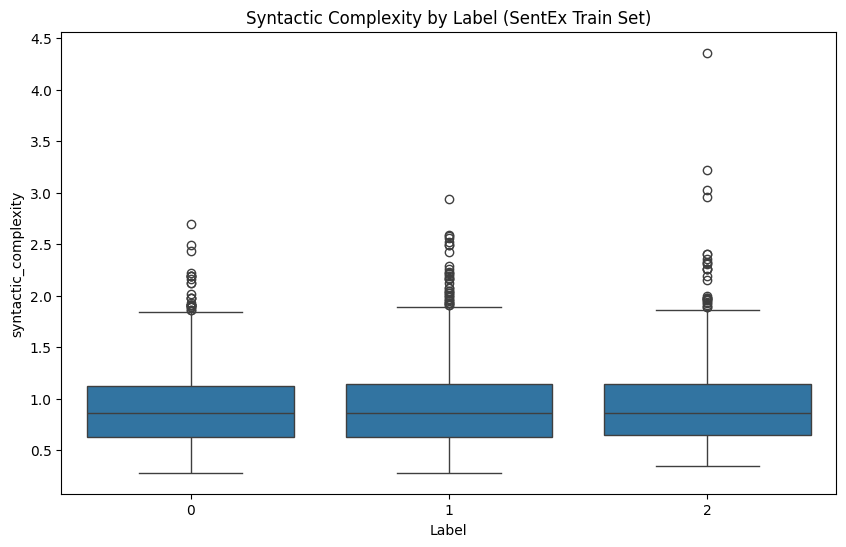

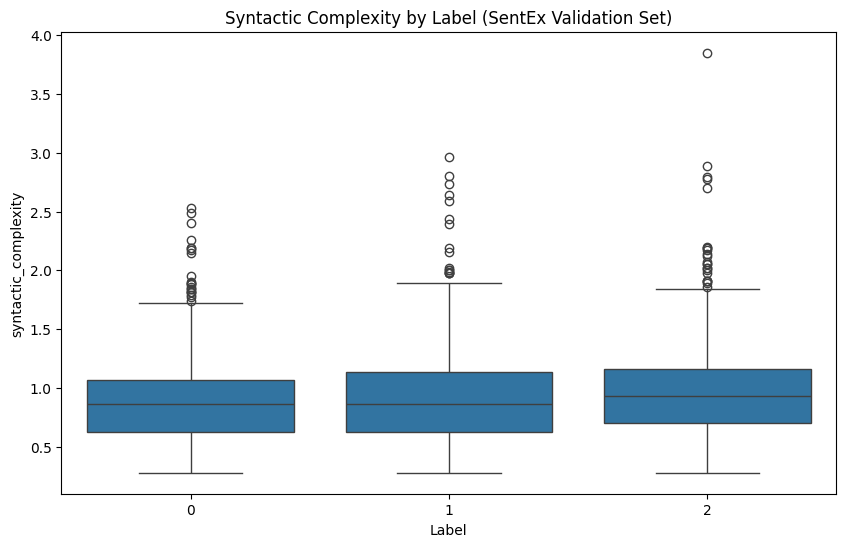

Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.9267674031023901, p-value = 4.175309574333342e-38
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.9085553761228201, p-value = 8.993854001071106e-29
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.9317818777844371, p-value = 4.425723740053829e-37
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.922403349300157, p-value = 9.318313580000767e-27
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 0.41690642435573455, p-value = 0.6591158490306737
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene Te

In [22]:
# plot the syntactic_complexity by label
import matplotlib.pyplot as plt
import seaborn as sns

def plot_claim_var(data, column, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y=column, data=data)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel(column)
    plt.show()

plot_claim_var(train_sentEx, 'syntactic_complexity', 'Syntactic Complexity by Label (SentEx Train Set)')
plot_claim_var(valid_sentEx, 'syntactic_complexity', 'Syntactic Complexity by Label (SentEx Validation Set)')

# Check for normality using Shapiro-Wilk test
def check_normality(data, column, title):
    stat, p = shapiro(data[column])
    print('Shapiro Test Results for ' + title + ':')
    print(f'Shapiro stat = {stat}, p-value = {p}')
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print("--------------------------------------------\n")
check_normality(train_sentEx, 'syntactic_complexity', 'SentEx Train Set')
check_normality(valid_sentEx, 'syntactic_complexity', 'SentEx Validation Set')
check_normality(train_clf, 'syntactic_complexity', 'CLF Train Set')
check_normality(valid_clf, 'syntactic_complexity', 'CLF Validation Set')

# Check for homogeneity of variance using Levene's test
from scipy.stats import levene
def check_homogeneity(data, column, title):
    groups = data.groupby('label')[column].apply(list)
    stat, p = levene(*groups)
    print('Levene Test Results for ' + title + ':')
    print(f'Levene stat = {stat}, p-value = {p}')
    alpha = 0.05
    if p > alpha:
        print('Homogeneity of variance (fail to reject H0)')
    else:
        print('Not homogenous (reject H0)')
    print("--------------------------------------------\n")
check_homogeneity(train_sentEx, 'syntactic_complexity', 'SentEx Train Set')
check_homogeneity(valid_sentEx, 'syntactic_complexity', 'SentEx Validation Set')
check_homogeneity(train_clf, 'syntactic_complexity', 'CLF Train Set')
check_homogeneity(valid_clf, 'syntactic_complexity', 'CLF Validation Set')


In [ ]:
import statsmodels.formula.api as smf # import the formula API from statsmodels
from scipy.stats import kruskal

# Ordinal encode the label column
train_sentEx['label'] = train_sentEx['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})
valid_sentEx['label'] = valid_sentEx['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})
train_clf['label'] = train_clf['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})
valid_clf['label'] = valid_clf['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})


# Perform an ANOVA on label and syntactic_complexity using statsmodels
model = smf.ols('label ~ syntactic_complexity', data=train_sentEx).fit() #refer to formula API using the alias smf
print(model.summary())
print("--------------------------------------------\n")

# Perform a Kruskal-Wallis test
def kruskal_test(data, column, title):
    groups = data.groupby('label')[column].apply(list)
    stat, p = kruskal(*groups)
    print('Kruskal-Wallis Test Results for ' + title + ':')
    print(f'Kruskal stat = {stat}, p-value = {p}')
    alpha = 0.05
    if p > alpha:
        print('Median ranks are equal (fail to reject H0)')
    else:
        print('Median ranks are not equal (reject H0)')
    print("--------------------------------------------\n")
kruskal_test(train_sentEx, 'syntactic_complexity', 'SentEx Train Set')
kruskal_test(valid_sentEx, 'syntactic_complexity', 'SentEx Validation Set')
kruskal_test(train_clf, 'syntactic_complexity', 'CLF Train Set')
kruskal_test(valid_clf, 'syntactic_complexity', 'CLF Validation Set')


                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.291
Date:                Sat, 12 Apr 2025   Prob (F-statistic):             0.0384
Time:                        17:10:02   Log-Likelihood:                -4190.1
No. Observations:                3447   AIC:                             8384.
Df Residuals:                    3445   BIC:                             8397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9335 

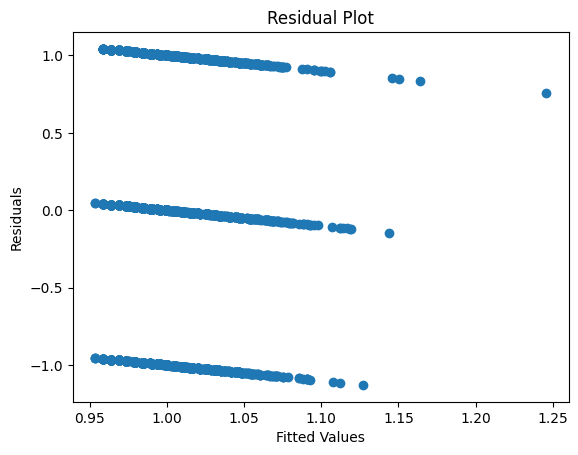

In [ ]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Parse tree depth

In [19]:
import spacy
import tqdm
from tqdm import tqdm # Import pandas from tqdm for DataFrame integration


# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

def calculate_parse_tree_depth(sentence):
    """
    Calculate the depth of the dependency parse tree for a given sentence.
    """
    doc = nlp(sentence)
    def get_depth(token):
        if not list(token.children):  # If the token has no children, depth is 1
            return 1
        return 1 + max(get_depth(child) for child in token.children)

    # Get the depth of the root token
    return max(get_depth(sent.root) for sent in doc.sents)


# Calculate parse tree depth for each sentence in the dataset with a progress bar
def calculate_parse_tree_depth_for_dataset(dataset):
    tqdm.pandas(desc="Calculating parse tree depth")
    dataset['parse_tree_depth'] = dataset['claim'].progress_apply(calculate_parse_tree_depth)
    return dataset


for dataset, name in zip([train_sentEx, valid_sentEx, train_clf, valid_clf],
                      ['train_sentEx', 'valid_sentEx', 'train_clf', 'valid_clf']):
    dataset = calculate_parse_tree_depth_for_dataset(dataset)
    # Save the updated dataset
    dataset.to_csv(f"{name}_with_parse_tree_depth.csv", index=False)
    print(f"Parse tree depth statistics for {name}:")
    print(dataset['parse_tree_depth'].describe())
    print("--------------------------------------------\n")

Calculating parse tree depth: 100%|██████████| 3447/3447 [00:26<00:00, 131.10it/s]


Parse tree depth statistics for train_sentEx:
count    3447.000000
mean        4.303452
std         1.298755
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        13.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------



Calculating parse tree depth: 100%|██████████| 1464/1464 [00:11<00:00, 131.25it/s]


Parse tree depth statistics for valid_sentEx:
count    1464.000000
mean        4.290301
std         1.289217
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        12.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------



Calculating parse tree depth: 100%|██████████| 3447/3447 [00:24<00:00, 140.63it/s]


Parse tree depth statistics for train_clf:
count    3447.000000
mean        4.284305
std         1.297726
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------



Calculating parse tree depth: 100%|██████████| 1458/1458 [00:09<00:00, 147.16it/s]

Parse tree depth statistics for valid_clf:
count    1458.000000
mean        4.202332
std         1.209466
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: parse_tree_depth, dtype: float64
--------------------------------------------



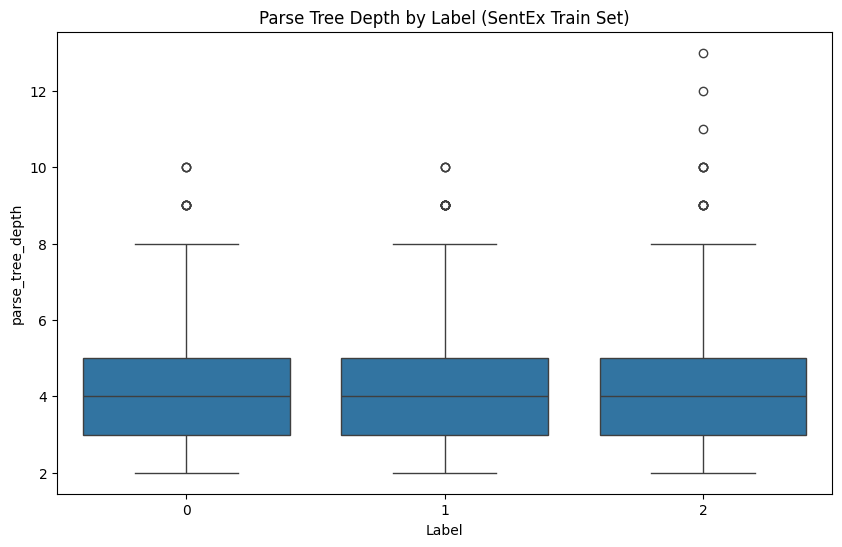

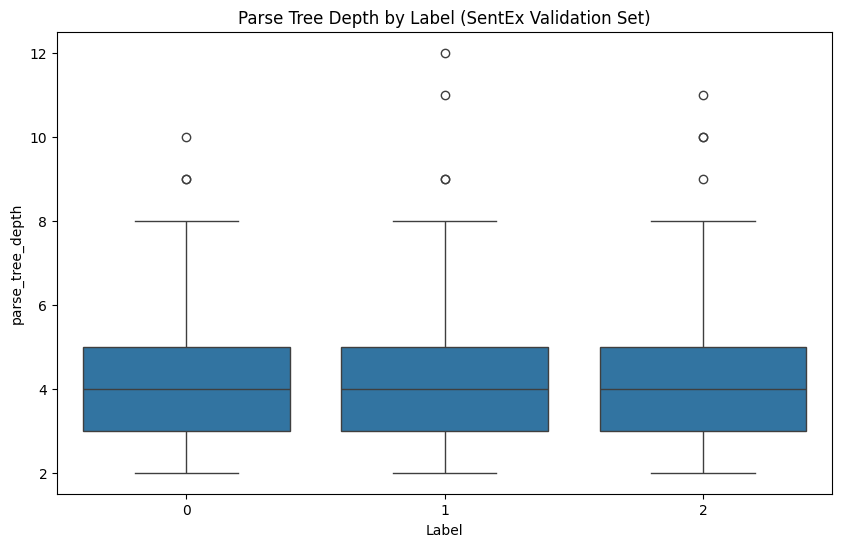

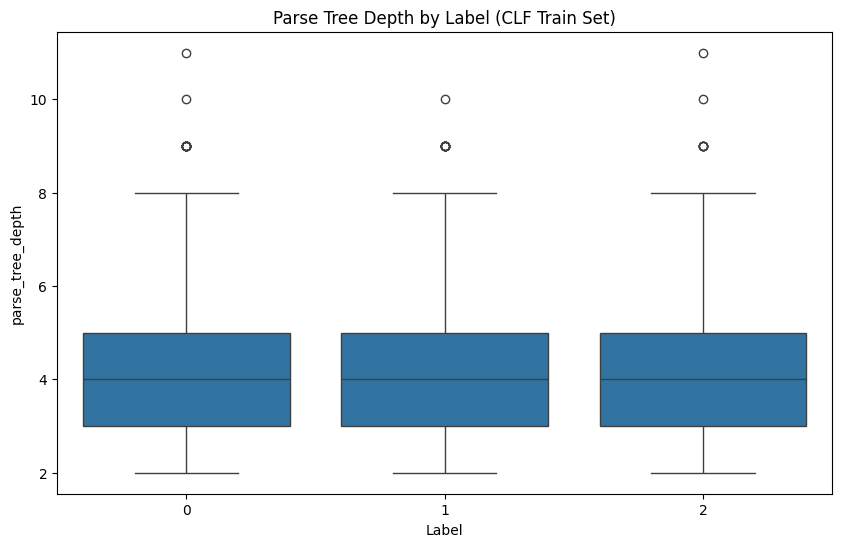

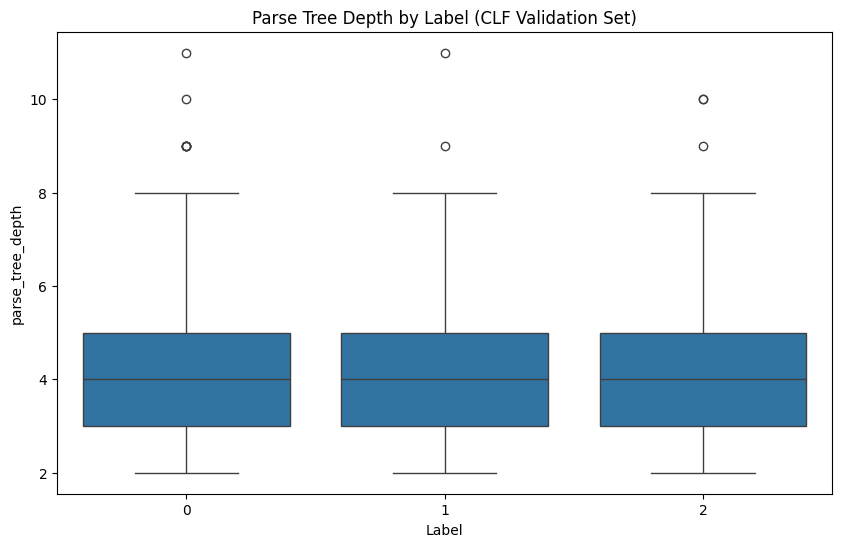

Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.8541980045619905, p-value = 8.083416919027425e-49
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.8618641938584015, p-value = 4.9786427651563084e-34
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.8658857083064015, p-value = 1.9097128228390212e-47
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.8445885852648509, p-value = 1.48532946222568e-35
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 0.9636214635762388, p-value = 0.38161159847036896
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene 

In [23]:
# plot parse_tree_depth
plot_claim_var(train_sentEx, 'parse_tree_depth', 'Parse Tree Depth by Label (SentEx Train Set)')
plot_claim_var(valid_sentEx, 'parse_tree_depth', 'Parse Tree Depth by Label (SentEx Validation Set)')
plot_claim_var(train_clf, 'parse_tree_depth', 'Parse Tree Depth by Label (CLF Train Set)')
plot_claim_var(valid_clf, 'parse_tree_depth', 'Parse Tree Depth by Label (CLF Validation Set)')

# Check normality
check_normality(train_sentEx, 'parse_tree_depth', 'SentEx Train Set')
check_normality(valid_sentEx, 'parse_tree_depth', 'SentEx Validation Set')
check_normality(train_clf, 'parse_tree_depth', 'CLF Train Set')
check_normality(valid_clf, 'parse_tree_depth', 'CLF Validation Set')

# Check homegeneity of variance
check_homogeneity(train_sentEx, 'parse_tree_depth', 'SentEx Train Set')
check_homogeneity(valid_sentEx, 'parse_tree_depth', 'SentEx Validation Set')
check_homogeneity(train_clf, 'parse_tree_depth', 'CLF Train Set')
check_homogeneity(valid_clf, 'parse_tree_depth', 'CLF Validation Set')


In [25]:
parse_model = smf.ols('label ~ parse_tree_depth', data=train_sentEx).fit() #refer to formula API using the alias smf
print(parse_model.summary())
print("--------------------------------------------\n")

# Kruskal Wallis test
kruskal_test(train_sentEx, 'parse_tree_depth', 'SentEx Train Set')
kruskal_test(valid_sentEx, 'parse_tree_depth', 'SentEx Validation Set')
kruskal_test(train_clf, 'parse_tree_depth', 'CLF Train Set')
kruskal_test(valid_clf, 'parse_tree_depth', 'CLF Validation Set')

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6194
Date:                Sat, 12 Apr 2025   Prob (F-statistic):              0.431
Time:                        20:28:09   Log-Likelihood:                -4192.0
No. Observations:                3447   AIC:                             8388.
Df Residuals:                    3445   BIC:                             8400.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.9637      0.048  